# Analysing World Health Statistics 2020 Complete Geo-Analysis

Data retireived [here](https://www.kaggle.com/datasets/utkarshxy/who-worldhealth-statistics-2020-complete) in Kaggle

The aim of this analysis is to predict the life expectancy based on the following variables:
- maternal mortality ratio;
- child mortality rate;
- incidence of Malaria;
- incidence of Tubercolosis;
- prevalence of hepatitis;
- probability of dying between the age of 30 and exact age of 70 from any of the cardiovascular disease, cancer, diabetes, or chronic respiratory disease;
- suicide rate;
- alcohol consumption;
- road traffic deaths rate;
- adolescence birth rate;
-  population with household expenditures on health greater than 25% of total household expenditure or income (SDG indicator 3.8.2) (%);
- ambient and household air pollution attributable death rate;
- prevalence of current tobacco use;
- medical doctors per 10,000 population;
- nursing and midwifery personnel per 10,000 population;
- population using at least basic drinking water services (%) sanitation and hygiene;
- proportion of population with primary reliance on clean fuels and technologies (%).

This analysis is inspired by chapter 2 of Aurélien Géron's "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow", O'Reilly, 2022, 3rd ed.

In [1]:
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "/home/lisa/Documents/ml-projects/world-health-statistics-2020/data"

For this first analysis I will ignore the temporal information by selecting only observations corresponding to one year.

In [3]:
# read in life expectancy data
lifeexp_file = join(path, "lifeExpectancyAtBirth.csv")
lifeexp      = pd.read_csv(lifeexp_file)
lifeexp      = lifeexp.loc[lifeexp["Dim1"] == "Both sexes"] # let's just select aggregate data for both sexes
del lifeexp["Dim1"]
lifeexp["Indicator"] = lifeexp["Indicator"].str.rsplit(" (", 1).str[0].str.replace(" ", "_")
lifeexp

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2019,Life_expectancy_at_birth,63.21
3,Afghanistan,2015,Life_expectancy_at_birth,61.65
6,Afghanistan,2010,Life_expectancy_at_birth,59.94
9,Afghanistan,2000,Life_expectancy_at_birth,54.99
12,Albania,2019,Life_expectancy_at_birth,78.00
...,...,...,...,...
2182,Zambia,2000,Life_expectancy_at_birth,44.46
2185,Zimbabwe,2019,Life_expectancy_at_birth,60.68
2188,Zimbabwe,2015,Life_expectancy_at_birth,58.48
2191,Zimbabwe,2010,Life_expectancy_at_birth,51.49


In [4]:
# read in maternal mortality ratio
matmort_file = join(path, "maternalMortalityRatio.csv")
matmort      = pd.read_csv(matmort_file)
matmort["First Tooltip"] = matmort["First Tooltip"].str.split( ).str[0].astype(float)
matmort["Indicator"] = matmort["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
matmort

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2017,Maternal_mortality_ratio,638.0
1,Afghanistan,2016,Maternal_mortality_ratio,673.0
2,Afghanistan,2015,Maternal_mortality_ratio,701.0
3,Afghanistan,2014,Maternal_mortality_ratio,786.0
4,Afghanistan,2013,Maternal_mortality_ratio,810.0
...,...,...,...,...
3289,Zimbabwe,2004,Maternal_mortality_ratio,686.0
3290,Zimbabwe,2003,Maternal_mortality_ratio,680.0
3291,Zimbabwe,2002,Maternal_mortality_ratio,666.0
3292,Zimbabwe,2001,Maternal_mortality_ratio,629.0


In [5]:
# read in child mortality data
chimort_file = join(path, "under5MortalityRate.csv")
chimort      = pd.read_csv(chimort_file)
chimort      = chimort.loc[chimort["Dim1"] == "Both sexes"]
del chimort["Dim1"]
chimort["First Tooltip"] = chimort["First Tooltip"].str.split( ).str[0].astype(float)
chimort["Indicator"] = chimort["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
chimort["Indicator"] = chimort["Indicator"].str.replace("-", "_")
chimort

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2019,Under_five_mortality_rate,60.27
3,Afghanistan,2018,Under_five_mortality_rate,62.54
6,Afghanistan,2017,Under_five_mortality_rate,64.94
9,Afghanistan,2016,Under_five_mortality_rate,67.57
12,Afghanistan,2015,Under_five_mortality_rate,70.44
...,...,...,...,...
29985,Timor-Leste,2005,Under_five_mortality_rate,81.27
29988,Timor-Leste,2004,Under_five_mortality_rate,86.34
29991,Timor-Leste,2003,Under_five_mortality_rate,91.59
29994,Timor-Leste,2002,Under_five_mortality_rate,96.97


In [6]:
# read in incidence of malaria
incimal_file = join(path, "incedenceOfMalaria.csv")
incimal      = pd.read_csv(incimal_file)
incimal["Indicator"] = incimal["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
incimal

,Location,Indicator,Period,First Tooltip
0,Afghanistan,Malaria_incidence,2018,29.01
1,Afghanistan,Malaria_incidence,2017,27.07
2,Afghanistan,Malaria_incidence,2016,26.11
3,Afghanistan,Malaria_incidence,2015,14.91
4,Afghanistan,Malaria_incidence,2014,12.67
...,...,...,...,...
2028,Zimbabwe,Malaria_incidence,2004,120.20
2029,Zimbabwe,Malaria_incidence,2003,120.90
2030,Zimbabwe,Malaria_incidence,2002,121.50
2031,Zimbabwe,Malaria_incidence,2001,122.10


In [7]:
# read in incidence of tubercolosis
incitub_file = join(path, "incedenceOfTuberculosis.csv")
incitub      = pd.read_csv(incitub_file)
incitub["First Tooltip"] = incitub["First Tooltip"].str.split( ).str[0].astype(float)
incitub["Indicator"] = incitub["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
incitub

,Location,Indicator,Period,First Tooltip
0,Afghanistan,Incidence_of_tuberculosis,2019,189.0
1,Afghanistan,Incidence_of_tuberculosis,2018,189.0
2,Afghanistan,Incidence_of_tuberculosis,2017,189.0
3,Afghanistan,Incidence_of_tuberculosis,2016,189.0
4,Afghanistan,Incidence_of_tuberculosis,2015,189.0
...,...,...,...,...
3852,Zimbabwe,Incidence_of_tuberculosis,2004,607.0
3853,Zimbabwe,Incidence_of_tuberculosis,2003,617.0
3854,Zimbabwe,Incidence_of_tuberculosis,2002,617.0
3855,Zimbabwe,Incidence_of_tuberculosis,2001,617.0


In [8]:
# read in hepatitis B data
hepatit_file = join(path, "hepatitusBsurfaceAntigen.csv")
hepatit      = pd.read_csv(hepatit_file)
hepatit["First Tooltip"] = hepatit["First Tooltip"].str.split( ).str[0].astype(float)
hepatit["Indicator"] = hepatit["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
hepatit

,Location,Indicator,Period,First Tooltip
0,Afghanistan,Hepatitis_B_surface_antigen,2015,0.50
1,Albania,Hepatitis_B_surface_antigen,2015,1.29
2,Algeria,Hepatitis_B_surface_antigen,2015,0.22
3,Andorra,Hepatitis_B_surface_antigen,2015,0.08
4,Angola,Hepatitis_B_surface_antigen,2015,4.85
...,...,...,...,...
189,Venezuela (Bolivarian Republic of),Hepatitis_B_surface_antigen,2015,0.62
190,Viet Nam,Hepatitis_B_surface_antigen,2015,1.20
191,Yemen,Hepatitis_B_surface_antigen,2015,2.54
192,Zambia,Hepatitis_B_surface_antigen,2015,1.84


In [9]:
# read in cancer data
cancdat_file = join(path, "30-70cancerChdEtc.csv")
cancdat      = pd.read_csv(cancdat_file)
cancdat      = cancdat.loc[cancdat["Dim1"] == "Both sexes"]
del cancdat["Dim1"]
cancdat.Indicator = "Prob_dying_cardiovascular_and_others"
cancdat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2016,Prob_dying_cardiovascular_and_others,29.8
3,Afghanistan,2015,Prob_dying_cardiovascular_and_others,29.8
6,Afghanistan,2010,Prob_dying_cardiovascular_and_others,31.7
9,Afghanistan,2005,Prob_dying_cardiovascular_and_others,34.1
12,Afghanistan,2000,Prob_dying_cardiovascular_and_others,34.4
...,...,...,...,...
2730,Zimbabwe,2016,Prob_dying_cardiovascular_and_others,19.3
2733,Zimbabwe,2015,Prob_dying_cardiovascular_and_others,19.4
2736,Zimbabwe,2010,Prob_dying_cardiovascular_and_others,21.1
2739,Zimbabwe,2005,Prob_dying_cardiovascular_and_others,22.5


In [10]:
# read in suicide data
suicdat_file = join(path, "crudeSuicideRates.csv")
suicdat      = pd.read_csv(suicdat_file)
suicdat      = suicdat.loc[suicdat["Dim1"] == "Both sexes"]
del suicdat["Dim1"]
suicdat["Indicator"] = suicdat["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
suicdat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2016,Crude_suicide_rates,0.0
3,Afghanistan,2015,Crude_suicide_rates,4.8
6,Afghanistan,2010,Crude_suicide_rates,5.1
9,Afghanistan,2005,Crude_suicide_rates,6.3
12,Afghanistan,2000,Crude_suicide_rates,5.7
...,...,...,...,...
2730,Zimbabwe,2016,Crude_suicide_rates,0.0
2733,Zimbabwe,2015,Crude_suicide_rates,10.6
2736,Zimbabwe,2010,Crude_suicide_rates,11.9
2739,Zimbabwe,2005,Crude_suicide_rates,13.9


In [11]:
# read in data about substance abuse
subsdat_file = join(path, "alcoholSubstanceAbuse.csv")
subsdat      = pd.read_csv(subsdat_file)
subsdat      = subsdat.loc[subsdat["Dim1"] == "Both sexes"]
del subsdat["Dim1"]
subsdat.Indicator = "Total_alcohol_consumption"
subsdat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2018,Total_alcohol_consumption,0.21
3,Afghanistan,2015,Total_alcohol_consumption,0.21
6,Afghanistan,2010,Total_alcohol_consumption,0.21
9,Albania,2018,Total_alcohol_consumption,7.17
12,Albania,2015,Total_alcohol_consumption,6.74
...,...,...,...,...
2772,Zimbabwe,2018,Total_alcohol_consumption,4.67
2775,Zimbabwe,2015,Total_alcohol_consumption,4.92
2778,Zimbabwe,2010,Total_alcohol_consumption,3.93
2781,Zimbabwe,2005,Total_alcohol_consumption,2.77


In [12]:
# read in data about road traffic deaths
roaddat_file = join(path, "roadTrafficDeaths.csv")
roaddat      = pd.read_csv(roaddat_file)
roaddat["Indicator"] = roaddat["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
roaddat

,Location,Indicator,Period,First Tooltip
0,Afghanistan,Estimated_road_traffic_death_rate,2016,15.1
1,Albania,Estimated_road_traffic_death_rate,2016,13.6
2,Angola,Estimated_road_traffic_death_rate,2016,23.6
3,Antigua and Barbuda,Estimated_road_traffic_death_rate,2016,7.9
4,Argentina,Estimated_road_traffic_death_rate,2016,14.0
...,...,...,...,...
170,Uzbekistan,Estimated_road_traffic_death_rate,2016,11.5
171,Vanuatu,Estimated_road_traffic_death_rate,2016,15.9
172,Venezuela (Bolivarian Republic of),Estimated_road_traffic_death_rate,2016,33.7
173,Viet Nam,Estimated_road_traffic_death_rate,2016,26.4


In [13]:
# read in data about adolescents giving birth
adolbir_file = join(path, "adolescentBirthRate.csv")
adolbir      = pd.read_csv(adolbir_file)
adolbir["Indicator"] = adolbir["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
adolbir

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2017,Adolescent_birth_rate,62.0
1,Afghanistan,2014,Adolescent_birth_rate,77.2
2,Afghanistan,2013,Adolescent_birth_rate,87.0
3,Afghanistan,2011,Adolescent_birth_rate,125.7
4,Afghanistan,2009,Adolescent_birth_rate,80.0
...,...,...,...,...
2184,Zimbabwe,2008,Adolescent_birth_rate,112.0
2185,Zimbabwe,2007,Adolescent_birth_rate,102.6
2186,Zimbabwe,2004,Adolescent_birth_rate,98.7
2187,Zimbabwe,2003,Adolescent_birth_rate,101.0


In [14]:
# read in data about percentage of people who spend more than 25% of their income for health
healexp_file = join(path, "population25SDG3.8.2.csv")
healexp      = pd.read_csv(healexp_file)
healexp      = healexp.loc[healexp["Dim1"] == "Total"]
del healexp["Dim1"]
healexp["Indicator"] = "Population_expending_more25pc_health"
healexp

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2013,Population_expending_more25pc_health,2.01
3,Afghanistan,2007,Population_expending_more25pc_health,0.07
6,Albania,2012,Population_expending_more25pc_health,4.95
9,Albania,2008,Population_expending_more25pc_health,4.08
12,Albania,2005,Population_expending_more25pc_health,4.50
...,...,...,...,...
1878,Yemen,1998,Population_expending_more25pc_health,1.35
1881,Zambia,2010,Population_expending_more25pc_health,0.01
1884,Zambia,2006,Population_expending_more25pc_health,0.43
1887,Zambia,2004,Population_expending_more25pc_health,0.53


In [15]:
# read in data on deaths attributed to pollution
polldat_file = join(path, "airPollutionDeathRate.csv")
polldat      = pd.read_csv(polldat_file)
polldat      = polldat.loc[polldat["Dim1"] == "Both sexes"]
polldat      = polldat.loc[polldat["Dim2"] == "Total"]
del polldat["Dim1"]
del polldat["Dim2"]
polldat["First Tooltip"] = polldat["First Tooltip"].str.split( ).str[0].astype(float)
polldat      = polldat.loc[polldat["Indicator"] == "Ambient and household air pollution attributable death rate (per 100 000 population)"]
polldat["Indicator"] = "Air_pollution_attributable_death_rate"
polldat

,Location,Indicator,Period,First Tooltip
0,Afghanistan,Air_pollution_attributable_death_rate,2016,95.12
36,Albania,Air_pollution_attributable_death_rate,2016,104.70
72,Algeria,Air_pollution_attributable_death_rate,2016,40.33
108,Angola,Air_pollution_attributable_death_rate,2016,67.25
144,Antigua and Barbuda,Air_pollution_attributable_death_rate,2016,28.29
...,...,...,...,...
6408,Venezuela (Bolivarian Republic of),Air_pollution_attributable_death_rate,2016,28.95
6444,Viet Nam,Air_pollution_attributable_death_rate,2016,65.14
6480,Yemen,Air_pollution_attributable_death_rate,2016,89.75
6516,Zambia,Air_pollution_attributable_death_rate,2016,63.39


In [16]:
# prevalence of tobacco use in people aged > 15 old
tobadat_file = join(path, "tobaccoAge15.csv")
tobadat      = pd.read_csv(tobadat_file)
tobadat      = tobadat.loc[tobadat["Dim1"]=="Both sexes"]
del tobadat["Dim1"]
tobadat.Indicator = "Prevalence_of_tobacco_smokers"
tobadat

,Location,Indicator,Period,First Tooltip
0,Albania,Prevalence_of_tobacco_smokers,2018,29.2
3,Albania,Prevalence_of_tobacco_smokers,2017,29.3
6,Albania,Prevalence_of_tobacco_smokers,2016,29.7
9,Albania,Prevalence_of_tobacco_smokers,2015,29.9
12,Albania,Prevalence_of_tobacco_smokers,2014,30.1
...,...,...,...,...
4008,Zimbabwe,Prevalence_of_tobacco_smokers,2014,14.7
4011,Zimbabwe,Prevalence_of_tobacco_smokers,2013,14.9
4014,Zimbabwe,Prevalence_of_tobacco_smokers,2010,15.6
4017,Zimbabwe,Prevalence_of_tobacco_smokers,2005,17.0


In [17]:
# read in data about number of medical doctors per 10k people
medddat_file = join(path, "medicalDoctors.csv")
medddat      = pd.read_csv(medddat_file)
medddat["Indicator"] = medddat["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
medddat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2016,Medical_doctors,2.78
1,Afghanistan,2015,Medical_doctors,2.85
2,Afghanistan,2014,Medical_doctors,2.98
3,Afghanistan,2013,Medical_doctors,2.85
4,Afghanistan,2012,Medical_doctors,2.41
...,...,...,...,...
2501,Zimbabwe,2005,Medical_doctors,1.26
2502,Zimbabwe,2004,Medical_doctors,1.74
2503,Zimbabwe,2000,Medical_doctors,1.26
2504,Zimbabwe,1995,Medical_doctors,1.43


In [18]:
# read in data about nurses and midwifes per 10k people
nursdat_file = join(path, "nursingAndMidwife.csv")
nursdat      = pd.read_csv(nursdat_file)
nursdat["Indicator"] = nursdat["Indicator"].str.rsplit(" (").str[0].str.replace(" ", "_")
nursdat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2017,Nursing_and_midwifery_personnel,1.76
1,Afghanistan,2016,Nursing_and_midwifery_personnel,1.48
2,Afghanistan,2015,Nursing_and_midwifery_personnel,1.30
3,Afghanistan,2014,Nursing_and_midwifery_personnel,1.48
4,Afghanistan,2013,Nursing_and_midwifery_personnel,2.50
...,...,...,...,...
2582,Zimbabwe,2011,Nursing_and_midwifery_personnel,13.20
2583,Zimbabwe,2010,Nursing_and_midwifery_personnel,8.29
2584,Zimbabwe,2009,Nursing_and_midwifery_personnel,9.49
2585,Zimbabwe,1995,Nursing_and_midwifery_personnel,15.27


In [19]:
# read in data about percentage of people using drinking water services
driwdat_file = join(path, "basicDrinkingWaterServices.csv")
driwdat      = pd.read_csv(driwdat_file)
driwdat.Indicator = "Population_using_basic_drinking-water_services"
driwdat

,Location,Period,Indicator,First Tooltip
0,Afghanistan,2017,Population_using_basic_drinking-water_services,57.32
1,Afghanistan,2016,Population_using_basic_drinking-water_services,54.84
2,Afghanistan,2015,Population_using_basic_drinking-water_services,52.39
3,Afghanistan,2014,Population_using_basic_drinking-water_services,49.96
4,Afghanistan,2013,Population_using_basic_drinking-water_services,47.56
...,...,...,...,...
3450,Zimbabwe,2004,Population_using_basic_drinking-water_services,57.94
3451,Zimbabwe,2003,Population_using_basic_drinking-water_services,58.59
3452,Zimbabwe,2002,Population_using_basic_drinking-water_services,59.23
3453,Zimbabwe,2001,Population_using_basic_drinking-water_services,59.88


In [20]:
# read in data about people using safe sanitation services
sanidat_file = join(path, "safelySanitization.csv")
sanidat      = pd.read_csv(sanidat_file)
sanidat      = sanidat.loc[sanidat["Dim1"] == "Total"]
del sanidat["Dim1"]
sanidat.Indicator = "Population_using_sanitation_services"
sanidat

,Location,Indicator,Period,First Tooltip
0,Albania,Population_using_sanitation_services,2017,39.86
3,Albania,Population_using_sanitation_services,2016,39.85
6,Albania,Population_using_sanitation_services,2015,39.84
9,Albania,Population_using_sanitation_services,2014,39.83
12,Albania,Population_using_sanitation_services,2013,39.60
...,...,...,...,...
3614,Venezuela (Bolivarian Republic of),Population_using_sanitation_services,2009,26.82
3615,Venezuela (Bolivarian Republic of),Population_using_sanitation_services,2008,27.24
3616,Venezuela (Bolivarian Republic of),Population_using_sanitation_services,2007,27.65
3617,Venezuela (Bolivarian Republic of),Population_using_sanitation_services,2006,28.07


In [21]:
# read in data about percentage of population using clean energy and fuel
clefdat_file = join(path, "cleanFuelAndTech.csv")
clefdat      = pd.read_csv(clefdat_file)
clefdat["First Tooltip"] = clefdat["First Tooltip"].astype(float)
clefdat.Indicator = "Population_with_clean_fuels_and_technologies"

Let's merge all the datasets in a single long dataset.

In [22]:
df_long = pd.concat([lifeexp, matmort, chimort, incimal, incitub, hepatit, cancdat, suicdat, subsdat,
                    roaddat, adolbir, healexp, polldat, tobadat, medddat, nursdat, driwdat, sanidat, clefdat])

In [23]:
df_long.columns = df_long.columns.str.replace("First Tooltip", "Value")
df_long

,Location,Period,Indicator,Value
0,Afghanistan,2019,Life_expectancy_at_birth,63.21
3,Afghanistan,2015,Life_expectancy_at_birth,61.65
6,Afghanistan,2010,Life_expectancy_at_birth,59.94
9,Afghanistan,2000,Life_expectancy_at_birth,54.99
12,Albania,2019,Life_expectancy_at_birth,78.00
...,...,...,...,...
3605,Zimbabwe,2004,Population_with_clean_fuels_and_technologies,33.00
3606,Zimbabwe,2003,Population_with_clean_fuels_and_technologies,33.00
3607,Zimbabwe,2002,Population_with_clean_fuels_and_technologies,34.00
3608,Zimbabwe,2001,Population_with_clean_fuels_and_technologies,34.00


Let's now make the dataframe wide:

In [24]:
df = pd.pivot(df_long, 
              columns=["Indicator"], 
              values=["Value"],
              index=["Location", "Period"])
df

Value  \
Indicator          Adolescent_birth_rate   
Location    Period                         
Afghanistan 1962                     NaN   
            1963                     NaN   
            1964                     NaN   
            1965                     NaN   
            1966                     NaN   
...                                  ...   
Zimbabwe    2015                     NaN   
            2016                     NaN   
            2017                    77.6   
            2018                     NaN   
            2019                     NaN   

                                                                              \
Indicator          Air_pollution_attributable_death_rate Crude_suicide_rates   
Location    Period                                                             
Afghanistan 1962                                     NaN                 NaN   
            1963                                     NaN                 NaN   
            1964                                     NaN                 NaN   
            1965                                     NaN                 NaN   
            1966                                     NaN                 NaN   
...                                                  ...                 ...   
Zimbabwe    2015                                     NaN                10.6   
            2016                                   66.67                 0.0   
            2017                                     NaN                 NaN   
            2018                                     NaN                 NaN   
            2019                                     NaN                 NaN   

                                                      \
Indicator          Estimated_road_traffic_death_rate   
Location    Period                                     
Afghanistan 1962                                 NaN   
            1963                                 NaN   
            1964                                 NaN   
            1965                                 NaN   
            1966                                 NaN   
...                                              ...   
Zimbabwe    2015                                 NaN   
            2016                                34.7   
            2017                                 NaN   
            2018                                 NaN   
            2019                                 NaN   

                                                                          \
Indicator          Hepatitis_B_surface_antigen Incidence_of_tuberculosis   
Location    Period                                                         
Afghanistan 1962                           NaN                       NaN   
            1963                           NaN                       NaN   
            1964                           NaN                       NaN   
            1965                           NaN                       NaN   
            1966                           NaN                       NaN   
...                                        ...                       ...   
Zimbabwe    2015                          4.38                     242.0   
            2016                           NaN                     233.0   
            2017                           NaN                     221.0   
            2018                           NaN                     210.0   
            2019                           NaN                     199.0   

                                                               \
Indicator          Life_expectancy_at_birth Malaria_incidence   
Location    Period                                              
Afghanistan 1962                        NaN               NaN   
            1963                        NaN               NaN   
            1964                        NaN               NaN   
            1965                        NaN              

Let's select just one year and possibly discard some features.

Let's pick the year with the least number of missing values.

In [25]:
obs_years = np.array(df.index.get_level_values(1))

In [26]:
nan_counts = []

for i in set(obs_years): # using set to avoid duplicates
    
    # create dataset corresponding to current year
    df_y = df.iloc[df.index.get_level_values('Period') == i]
    
    # getting ratio between how many missing values (normalized by the number of features) are there 
    # on total observations
    nans = np.divide(np.divide(df_y.isna().sum().sum(), len(df_y.isna().sum())), len(df_y))
    
    # storing info on how many missing values are there per each year
    nan_counts.append(('Year: %s' % str(i), round(nans, 2), 'Total observations: %i' % len(df_y)))
    
# pick the year with lower nan ratio
min_ratio = min(x[1] for x in nan_counts)
best_obs_idx = [idx for idx, tup in enumerate(nan_counts) if tup[1] == min_ratio]
print('The years with the least missing values appear to be: ', nan_counts[best_obs_idx[0]])

The years with the least missing values appear to be:  ('Year: 2015', 0.3, 'Total observations: 194')


Let's create a dataframe with data from 2015.

In [27]:
df_2015 = df.iloc[df.index.get_level_values('Period') == 2015]
df_2015

Value  \
Indicator                                 Adolescent_birth_rate   
Location                           Period                         
Afghanistan                        2015                     NaN   
Albania                            2015                    20.2   
Algeria                            2015                     9.7   
Andorra                            2015                     3.1   
Angola                             2015                     NaN   
...                                                         ...   
Venezuela (Bolivarian Republic of) 2015                     NaN   
Viet Nam                           2015                     NaN   
Yemen                              2015                     NaN   
Zambia                             2015                     NaN   
Zimbabwe                           2015                     NaN   

                                                                                 \
Indicator                                 Air_pollution_attributable_death_rate   
Location                           Period                                         
Afghanistan                        2015                                     NaN   
Albania                            2015                                     NaN   
Algeria                            2015                                     NaN   
Andorra                            2015                                     NaN   
Angola                             2015                                     NaN   
...                                                                         ...   
Venezuela (Bolivarian Republic of) 2015                                     NaN   
Viet Nam                           2015                                     NaN   
Yemen                              2015                                     NaN   
Zambia                             2015                                     NaN   
Zimbabwe                           2015                                     NaN   

                                                               \
Indicator                                 Crude_suicide_rates   
Location                           Period                       
Afghanistan                        2015                   4.8   
Albania                            2015                   6.0   
Algeria                            2015                   3.2   
Andorra                            2015                   NaN   
Angola                             2015                   5.0   
...                                                       ...   
Venezuela (Bolivarian Republic of) 2015                   3.8   
Viet Nam                           2015                   7.2   
Yemen                              2015                   8.6   
Zambia                             2015                   6.1   
Zimbabwe                           2015                  10.6   

                                                                             \
Indicator                                 Estimated_road_traffic_death_rate   
Location                           Period                                     
Afghanistan                        2015                                 NaN   
Albania                            2015                                 NaN   
Algeria                            2015                                 NaN   
Andorra                            2015                                 NaN   
Angola                             2015                                 NaN   
...                                                                     ...   
Venezuela (Bolivarian Republic of) 2015                                 NaN   
Viet Nam                           2015                                 NaN   
Yemen                              2015                                 NaN   
Zambia                             2015                                 NaN   
Zimbabwe          

In [28]:
round(np.divide(df_2015.isna().sum(), len(df_2015)), 2)

       Indicator                                     
Value  Adolescent_birth_rate                             0.45
       Air_pollution_attributable_death_rate             1.00
       Crude_suicide_rates                               0.06
       Estimated_road_traffic_death_rate                 1.00
       Hepatitis_B_surface_antigen                       0.00
       Incidence_of_tuberculosis                         0.00
       Life_expectancy_at_birth                          0.06
       Malaria_incidence                                 0.45
       Maternal_mortality_ratio                          0.06
       Medical_doctors                                   0.46
       Nursing_and_midwifery_personnel                   0.31
       Population_expending_more25pc_health              0.88
       Population_using_basic_drinking-water_services    0.01
       Population_using_sanitation_services              0.55
       Population_with_clean_fuels_and_technologies      0.02
       Prevalenc

Let's take only the columns with less than 25% of missing values:

In [29]:
ok_col_idx = df_2015.isna().sum()[np.divide(df_2015.isna().sum(), len(df_2015)) < 0.25].index
ok_col_idx
#ok_col = [x[1] for x in ok_col_idx]
#ok_col

MultiIndex([('Value',                            'Crude_suicide_rates'),
            ('Value',                    'Hepatitis_B_surface_antigen'),
            ('Value',                      'Incidence_of_tuberculosis'),
            ('Value',                       'Life_expectancy_at_birth'),
            ('Value',                       'Maternal_mortality_ratio'),
            ('Value', 'Population_using_basic_drinking-water_services'),
            ('Value',   'Population_with_clean_fuels_and_technologies'),
            ('Value',                  'Prevalence_of_tobacco_smokers'),
            ('Value',           'Prob_dying_cardiovascular_and_others'),
            ('Value',                      'Total_alcohol_consumption'),
            ('Value',                      'Under_five_mortality_rate')],
           names=[None, 'Indicator'])

In [30]:
df_ok = df_2015[df_2015.columns.intersection(ok_col_idx)]
df_ok

Value  \
Indicator                                 Crude_suicide_rates   
Location                           Period                       
Afghanistan                        2015                   4.8   
Albania                            2015                   6.0   
Algeria                            2015                   3.2   
Andorra                            2015                   NaN   
Angola                             2015                   5.0   
...                                                       ...   
Venezuela (Bolivarian Republic of) 2015                   3.8   
Viet Nam                           2015                   7.2   
Yemen                              2015                   8.6   
Zambia                             2015                   6.1   
Zimbabwe                           2015                  10.6   

                                                                       \
Indicator                                 Hepatitis_B_surface_antigen   
Location                           Period                               
Afghanistan                        2015                          0.50   
Albania                            2015                          1.29   
Algeria                            2015                          0.22   
Andorra                            2015                          0.08   
Angola                             2015                          4.85   
...                                                               ...   
Venezuela (Bolivarian Republic of) 2015                          0.62   
Viet Nam                           2015                          1.20   
Yemen                              2015                          2.54   
Zambia                             2015                          1.84   
Zimbabwe                           2015                          4.38   

                                                                     \
Indicator                                 Incidence_of_tuberculosis   
Location                           Period                             
Afghanistan                        2015                       189.0   
Albania                            2015                        17.0   
Algeria                            2015                        75.0   
Andorra                            2015                         5.9   
Angola                             2015                       366.0   
...                                                             ...   
Venezuela (Bolivarian Republic of) 2015                        30.0   
Viet Nam                           2015                       199.0   
Yemen                              2015                        48.0   
Zambia                             2015                       391.0   
Zimbabwe                           2015                       242.0   

                                                                    \
Indicator                                 Life_expectancy_at_birth   
Location                           Period                            
Afghanistan                        2015                      61.65   
Albania                            2015                      77.84   
Algeria                            2015                      76.54   
Andorra                            2015                        NaN   
Angola                             2015                      61.72   
...                                                            ...   
Venezuela (Bolivarian Republic of) 2015                      74.66   
Viet Nam                           2015                      73.16   
Yemen                              2015                      67.47   
Zambia                             2015                      60.50   
Zimbabwe                           2015                      58.48   

                                                                    \
Indicator                                 Maternal_mortality_ratio   
Locati

Let's further remove the examples with NaN for `Life_expectancy_at_birth` and `Under_five_mortality_rate` (see later).

In [31]:
df_ok = df_ok.dropna(axis=0, how='all', subset=[('Value','Under_five_mortality_rate')])
df_ok = df_ok.dropna(axis=0, how='all', subset=[('Value','Life_expectancy_at_birth')])
df_ok.isna().sum()

       Indicator                                     
Value  Crude_suicide_rates                                0
       Hepatitis_B_surface_antigen                        0
       Incidence_of_tuberculosis                          0
       Life_expectancy_at_birth                           0
       Maternal_mortality_ratio                           0
       Population_using_basic_drinking-water_services     0
       Population_with_clean_fuels_and_technologies       4
       Prevalence_of_tobacco_smokers                     35
       Prob_dying_cardiovascular_and_others               0
       Total_alcohol_consumption                          1
       Under_five_mortality_rate                          0
dtype: int64

In [32]:
df_ok

Value  \
Indicator                                        Crude_suicide_rates   
Location                                  Period                       
Afghanistan                               2015                   4.8   
Albania                                   2015                   6.0   
Algeria                                   2015                   3.2   
Angola                                    2015                   5.0   
Antigua and Barbuda                       2015                   0.8   
...                                                              ...   
Syrian Arab Republic                      2015                   1.9   
Tajikistan                                2015                   2.5   
Thailand                                  2015                  14.6   
The former Yugoslav Republic of Macedonia 2015                   7.8   
Timor-Leste                               2015                   4.6   

                                                                              \
Indicator                                        Hepatitis_B_surface_antigen   
Location                                  Period                               
Afghanistan                               2015                          0.50   
Albania                                   2015                          1.29   
Algeria                                   2015                          0.22   
Angola                                    2015                          4.85   
Antigua and Barbuda                       2015                          0.38   
...                                                                      ...   
Syrian Arab Republic                      2015                          0.37   
Tajikistan                                2015                          0.71   
Thailand                                  2015                          0.17   
The former Yugoslav Republic of Macedonia 2015                          0.20   
Timor-Leste                               2015                          0.87   

                                                                            \
Indicator                                        Incidence_of_tuberculosis   
Location                                  Period                             
Afghanistan                               2015                       189.0   
Albania                                   2015                        17.0   
Algeria                                   2015                        75.0   
Angola                                    2015                       366.0   
Antigua and Barbuda                       2015                         4.3   
...                                                                    ...   
Syrian Arab Republic                      2015                        20.0   
Tajikistan                                2015                        86.0   
Thailand                                  2015                       163.0   
The former Yugoslav Republic of Macedonia 2015                        17.0   
Timor-Leste                               2015                       498.0   

                                                                           \
Indicator                                        Life_expectancy_at_birth   
Location                                  Period                            
Afghanistan                               2015                      61.65   
Albania                                   2015                      77.84   
Algeria                                   2015                      76.54   
Angola                                    2015                      61.72   
Antigua and Barbuda                       2015                      76.14   
...                                                                   ...   
Syrian Arab Republic                      2015                      64.40   
Tajikistan                                2015                      68

Let's give a glance to the data:

In [33]:
df_ok.describe().round(2)

Value                              \
Indicator Crude_suicide_rates Hepatitis_B_surface_antigen   
count                  162.00                      162.00   
mean                     9.42                        1.42   
std                      6.31                        2.42   
min                      0.70                        0.01   
25%                      4.80                        0.24   
50%                      8.10                        0.56   
75%                     12.48                        1.48   
max                     34.90                       21.13   

                                                              \
Indicator Incidence_of_tuberculosis Life_expectancy_at_birth   
count                        162.00                   162.00   
mean                         126.47                    71.65   
std                          171.75                     7.76   
min                            0.00                    47.67   
25%                           13.00                    65.10   
50%                           52.00                    73.04   
75%                          172.75                    77.38   
max                          988.00                    83.62   

                                    \
Indicator Maternal_mortality_ratio   
count                       162.00   
mean                        170.45   
std                         248.88   
min                           2.00   
25%                          12.00   
50%                          59.50   
75%                         215.00   
max                        1180.00   

                                                          \
Indicator Population_using_basic_drinking-water_services   
count                                             162.00   
mean                                               80.38   
std                                                22.21   
min                                                22.34   
25%                                                66.18   
50%                                                89.30   
75%                                                98.87   
max                                               100.00   

                                                        \
Indicator Population_with_clean_fuels_and_technologies   
count                                           158.00   
mean                                             62.17   
std                                              36.82   
min                                               5.00   
25%                                              24.50   
50%                                              82.50   
75%                                              95.00   
max                                              95.00   

                                                                              \
Indicator Prevalence_of_tobacco_smokers Prob_dying_cardiovascular_and_others   
count                            127.00                               162.00   
mean                              23.12                                18.87   
std                               10.31                                 5.66   
min                                4.00                                 8.30   
25%                               15.05                                14.65   
50%                               23.40                                19.05   
75%                               29.15                                22.75   
max                               54.20                                30.80   

                                                               
Indicator Total_alcohol_consumption Under_five_mortality_rate  
count                        161.00                    162.00  
mean                           6.08                     31.80  
std                            4.23                     33.21  
min                            0.00                      2.23  
25%                     

In [34]:
df_ok.shape

(162, 11)

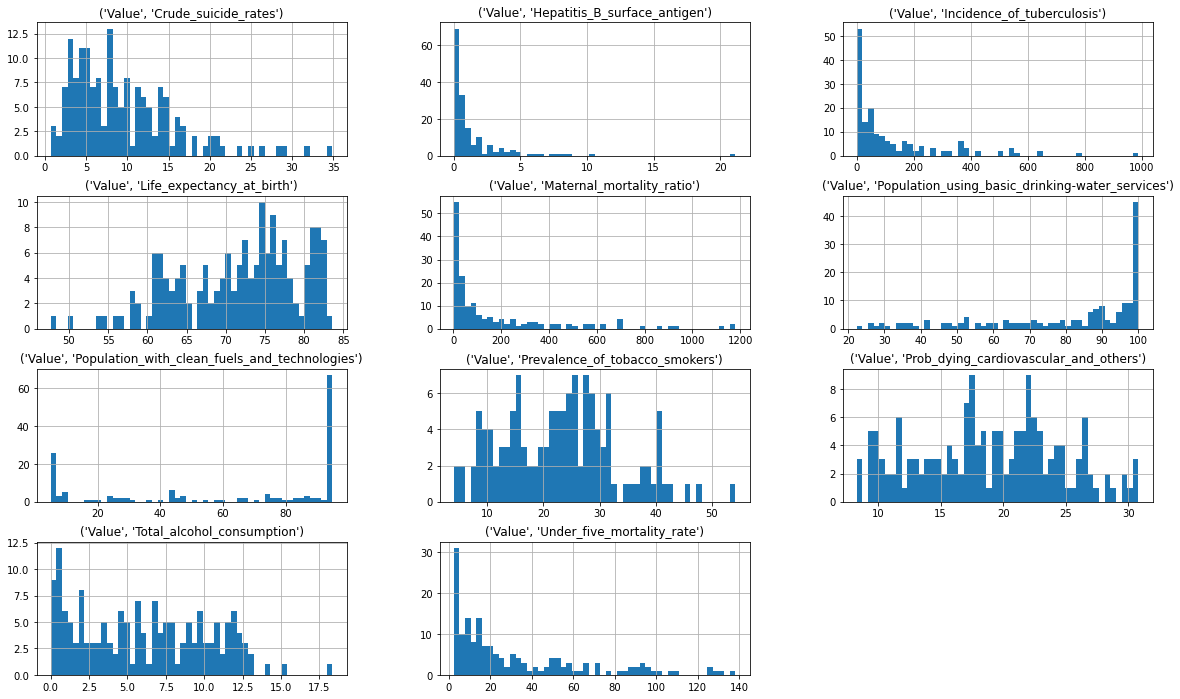

In [35]:
df_ok.hist(bins=50, figsize=(20, 12))
plt.show()

Before transforming and normalizing this data, let's take the test set. 
Since our dataset is not big at all, by randomly sampling the data we risk to introduce a significant sampling bias. Let's proceed with stratified sampling, by arbitrarily considering the `Under-five_mortality_rate` feature.

In [36]:
df_ok['Under-five_mortality_rate_cat'] = pd.cut(np.asarray(df_ok.iloc[:, df_ok.columns.get_level_values(1)=='Under_five_mortality_rate']).flatten(), 
                                                bins=[0, 20, 40, 60, 80, 100, np.inf],
                                                labels=[1, 2, 3, 4, 5, 6])

Let's plot an histogram of the newly created label:

[]

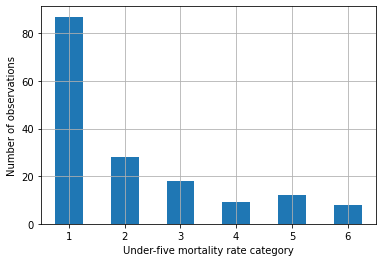

In [37]:
df_ok['Under-five_mortality_rate_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Under-five mortality rate category')
plt.ylabel('Number of observations')
plt.plot()

Now we are ready to do stratified sampling based on the Under-5 mortality rate category.

In [38]:
strat_train_set, strat_test_set = train_test_split(df_ok, test_size=0.2, 
                                                   stratify=df_ok['Under-five_mortality_rate_cat'],
                                                   random_state=1)

Let's see if it worked:

In [39]:
strat_test_set['Under-five_mortality_rate_cat'].value_counts() / len(strat_test_set)

1    0.545455
2    0.181818
3    0.121212
4    0.060606
5    0.060606
6    0.030303
Name: Under-five_mortality_rate_cat, dtype: float64

In [40]:
df_ok['Under-five_mortality_rate_cat'].value_counts() / len(df_ok['Under-five_mortality_rate_cat'])

1    0.537037
2    0.172840
3    0.111111
5    0.074074
4    0.055556
6    0.049383
Name: Under-five_mortality_rate_cat, dtype: float64

What if we did not use `stratify`?

In [41]:
train_set_, test_set_ = train_test_split(df_ok, test_size=0.2, random_state=1)

In [42]:
test_set_['Under-five_mortality_rate_cat'].value_counts() / len(test_set_)

1    0.515152
2    0.181818
5    0.121212
3    0.090909
6    0.090909
4    0.000000
Name: Under-five_mortality_rate_cat, dtype: float64

It is definitely better to use stratified sampling! :)
Ok, let's now remove the `Under-five_mortality_rate_cat` column.

In [43]:
del strat_train_set['Under-five_mortality_rate_cat']
del strat_test_set['Under-five_mortality_rate_cat']

## EDA

Let's make a copy of the training set, removing the multi-index:

In [44]:
df_full_train = strat_train_set.copy()

In [45]:
df_full_train = df_full_train.droplevel('Period')
df_full_train.columns = df_full_train.columns.droplevel()
df_full_train.columns.name = None
df_full_train

,Crude_suicide_rates,Hepatitis_B_surface_antigen,Incidence_of_tuberculosis,Life_expectancy_at_birth,Maternal_mortality_ratio,Population_using_basic_drinking-water_services,Population_with_clean_fuels_and_technologies,Prevalence_of_tobacco_smokers,Prob_dying_cardiovascular_and_others,Total_alcohol_consumption,Under_five_mortality_rate
Location,,,,,,,,,,,
Malaysia,5.4,0.17,90.0,74.95,30.0,89.93,95.0,22.8,17.3,0.85,8.05
Solomon Islands,4.9,2.93,86.0,64.74,112.0,63.01,8.0,38.4,24.4,1.55,22.30
Eswatini,13.1,0.85,648.0,54.05,435.0,59.37,48.0,10.8,26.6,9.84,59.23
Kyrgyzstan,8.1,0.50,136.0,71.59,66.0,81.39,76.0,28.4,26.2,7.59,22.33
Japan,19.4,1.95,16.0,83.62,5.0,98.93,95.0,23.4,8.6,7.87,2.75
...,...,...,...,...,...,...,...,...,...,...,...
Democratic Republic of the Congo,5.6,1.43,324.0,60.44,490.0,22.34,5.0,NaN,19.4,2.05,97.23
Jamaica,2.1,0.16,4.5,75.85,78.0,84.40,85.0,12.0,14.8,4.19,15.62
Mongolia,13.1,1.72,428.0,67.61,47.0,52.86,44.0,29.0,30.4,10.97,20.23


Let's now look for correlations, and in particular how much each feature correlates with the `Life_expectancy_at_birth` feature:

In [46]:
corr_matrix = df_full_train.corr()
corr_matrix['Life_expectancy_at_birth'].sort_values(ascending=False)

Life_expectancy_at_birth                          1.000000
Population_using_basic_drinking-water_services    0.819933
Population_with_clean_fuels_and_technologies      0.810478
Total_alcohol_consumption                         0.371417
Prevalence_of_tobacco_smokers                     0.201956
Crude_suicide_rates                               0.172071
Hepatitis_B_surface_antigen                      -0.550962
Incidence_of_tuberculosis                        -0.713319
Prob_dying_cardiovascular_and_others             -0.713813
Maternal_mortality_ratio                         -0.751256
Under_five_mortality_rate                        -0.875673
Name: Life_expectancy_at_birth, dtype: float64

It seems several features are highly correlated to `Life_expectancy_at_birth`!
Let's give them a closer glance:

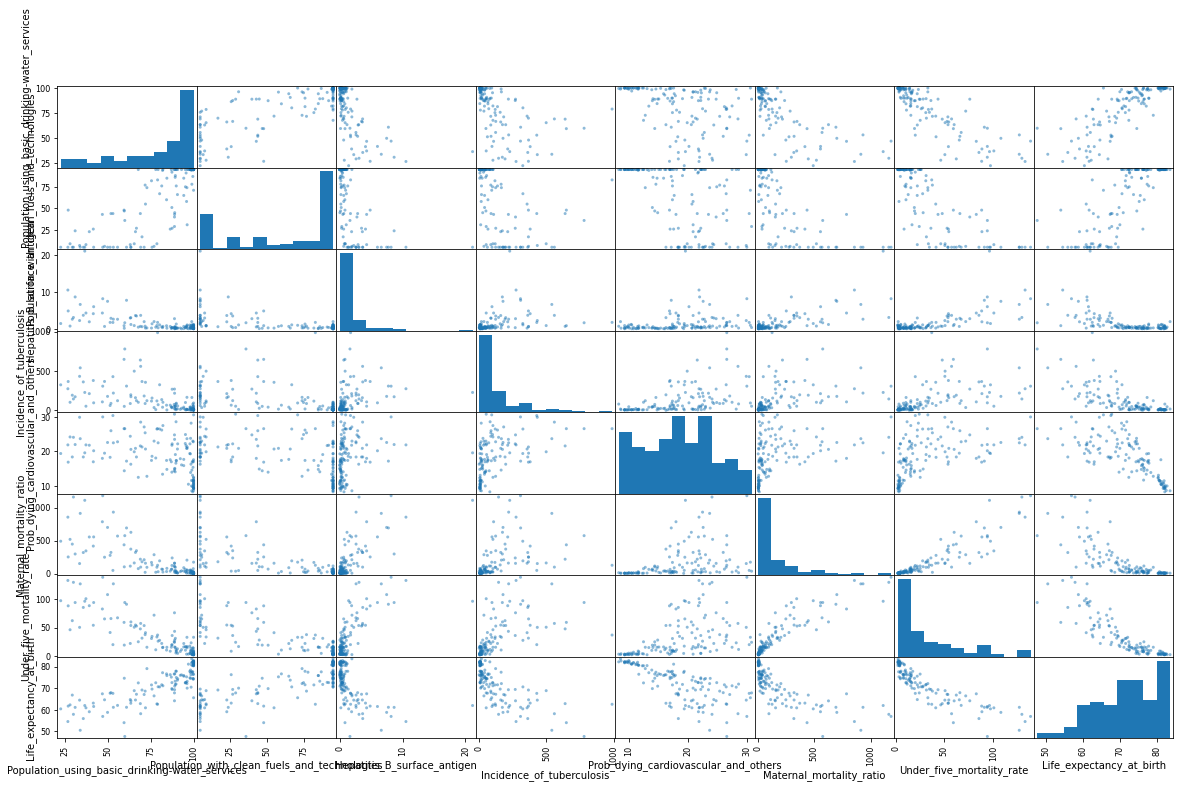

In [47]:
attributes  = ['Population_using_basic_drinking-water_services', 
               'Population_with_clean_fuels_and_technologies', 
               'Hepatitis_B_surface_antigen',
               'Incidence_of_tuberculosis',
               'Prob_dying_cardiovascular_and_others',
               'Maternal_mortality_ratio',
               'Under_five_mortality_rate',
               'Life_expectancy_at_birth']

scatter_matrix(df_full_train[attributes], figsize=(20, 12))
plt.show()

Let's now focus on the correlation between `Under_five_mortality_rate` and `Life_expectancy_at_birth`:

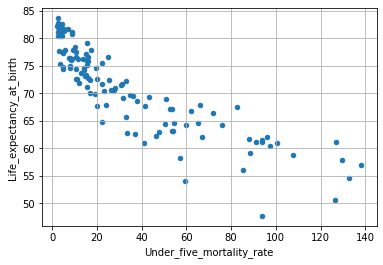

In [48]:
df_full_train.plot(kind='scatter', 
                   x='Under_five_mortality_rate',
                   y='Life_expectancy_at_birth', 
                   grid=True)
plt.show()

Let's now create a new feature and see how much it correlates with `Life_expectancy_at_birth`:

In [49]:
df_full_train['Cardiov_norm_tobacco'] = df_full_train['Prob_dying_cardiovascular_and_others'] / df_full_train['Prevalence_of_tobacco_smokers']
df_full_train

,Crude_suicide_rates,Hepatitis_B_surface_antigen,Incidence_of_tuberculosis,Life_expectancy_at_birth,Maternal_mortality_ratio,Population_using_basic_drinking-water_services,Population_with_clean_fuels_and_technologies,Prevalence_of_tobacco_smokers,Prob_dying_cardiovascular_and_others,Total_alcohol_consumption,Under_five_mortality_rate,Cardiov_norm_tobacco
Location,,,,,,,,,,,,
Malaysia,5.4,0.17,90.0,74.95,30.0,89.93,95.0,22.8,17.3,0.85,8.05,0.758772
Solomon Islands,4.9,2.93,86.0,64.74,112.0,63.01,8.0,38.4,24.4,1.55,22.30,0.635417
Eswatini,13.1,0.85,648.0,54.05,435.0,59.37,48.0,10.8,26.6,9.84,59.23,2.462963
Kyrgyzstan,8.1,0.50,136.0,71.59,66.0,81.39,76.0,28.4,26.2,7.59,22.33,0.922535
Japan,19.4,1.95,16.0,83.62,5.0,98.93,95.0,23.4,8.6,7.87,2.75,0.367521
...,...,...,...,...,...,...,...,...,...,...,...,...
Democratic Republic of the Congo,5.6,1.43,324.0,60.44,490.0,22.34,5.0,NaN,19.4,2.05,97.23,NaN
Jamaica,2.1,0.16,4.5,75.85,78.0,84.40,85.0,12.0,14.8,4.19,15.62,1.233333
Mongolia,13.1,1.72,428.0,67.61,47.0,52.86,44.0,29.0,30.4,10.97,20.23,1.048276


In [50]:
corr_matrix = df_full_train.corr()
corr_matrix['Life_expectancy_at_birth'].sort_values(ascending=False)

Life_expectancy_at_birth                          1.000000
Population_using_basic_drinking-water_services    0.819933
Population_with_clean_fuels_and_technologies      0.810478
Total_alcohol_consumption                         0.371417
Prevalence_of_tobacco_smokers                     0.201956
Crude_suicide_rates                               0.172071
Cardiov_norm_tobacco                             -0.546578
Hepatitis_B_surface_antigen                      -0.550962
Incidence_of_tuberculosis                        -0.713319
Prob_dying_cardiovascular_and_others             -0.713813
Maternal_mortality_ratio                         -0.751256
Under_five_mortality_rate                        -0.875673
Name: Life_expectancy_at_birth, dtype: float64

Ok, the new feature is not more correlated than `Prob_dying_cardiovascular_and_others`, so probably it is not very useful, and we will not add it in our dataset.

Let's now clean and transform data, and do feature scaling, but let's first create `y_train` and `y_test`, and remove our target variable from the training and test set.

## Cleaning and transforming data, feature scaling

Let's remove the Multi-Indexing and the target variable, and create a new dataset with just the target variable, for both the training and the test set.

In [51]:
strat_train_set = strat_train_set.droplevel('Period')
strat_train_set.columns = strat_train_set.columns.droplevel()
strat_train_set.columns.name = None
y_train = strat_train_set['Life_expectancy_at_birth']
del strat_train_set['Life_expectancy_at_birth']
# verify whether there are missing values
strat_train_set.isna().sum()

Crude_suicide_rates                                0
Hepatitis_B_surface_antigen                        0
Incidence_of_tuberculosis                          0
Maternal_mortality_ratio                           0
Population_using_basic_drinking-water_services     0
Population_with_clean_fuels_and_technologies       3
Prevalence_of_tobacco_smokers                     26
Prob_dying_cardiovascular_and_others               0
Total_alcohol_consumption                          1
Under_five_mortality_rate                          0
dtype: int64

In [52]:
strat_test_set = strat_test_set.droplevel('Period')
strat_test_set.columns = strat_test_set.columns.droplevel()
strat_test_set.columns.name = None
y_test = strat_test_set['Life_expectancy_at_birth']
del strat_test_set['Life_expectancy_at_birth']
# verify whether there are missing values 
strat_test_set.isna().sum()

Crude_suicide_rates                               0
Hepatitis_B_surface_antigen                       0
Incidence_of_tuberculosis                         0
Maternal_mortality_ratio                          0
Population_using_basic_drinking-water_services    0
Population_with_clean_fuels_and_technologies      1
Prevalence_of_tobacco_smokers                     9
Prob_dying_cardiovascular_and_others              0
Total_alcohol_consumption                         0
Under_five_mortality_rate                         0
dtype: int64

In [53]:
y_train.isna().sum()

0

In [54]:
y_test.isna().sum()

0

Now, let's demonstratively impute the missing values. The true imputation process will happen within the pipeline (see below). Let's use sklearn's `SimpleImputer`: it will store the median value of each feature: in this way, it will be possible to impute missing values not only on the training set, but also on the validation set, the test set, and any new data fed to the model.

Let's first create a `SimpleImputer` instance, specifying that we want to replace each attribute's missing values with the median of that attribute (N.B.: we have no categorical attributes!).

In [55]:
imputer = SimpleImputer(strategy="median")

We can now fit the `imputer` instance to the training data using the `fit()` method:

In [56]:
imputer.fit(strat_train_set)

SimpleImputer(strategy='median')

The `imputer` has simply computed the median of each attribute and stored the result in its `statistics_` instance variable. 

In [57]:
imputer.statistics_

array([ 8.1  ,  0.6  , 52.   , 54.   , 88.97 , 80.   , 22.9  , 18.4  ,
        5.825, 16.76 ])

Now we can use this "trained" `imputer` to transform the training set by replacing missing values with the learned medians:

In [58]:
X = imputer.transform(strat_train_set)
X

array([[5.400e+00, 1.700e-01, 9.000e+01, ..., 1.730e+01, 8.500e-01,
        8.050e+00],
       [4.900e+00, 2.930e+00, 8.600e+01, ..., 2.440e+01, 1.550e+00,
        2.230e+01],
       [1.310e+01, 8.500e-01, 6.480e+02, ..., 2.660e+01, 9.840e+00,
        5.923e+01],
       ...,
       [1.310e+01, 1.720e+00, 4.280e+02, ..., 3.040e+01, 1.097e+01,
        2.023e+01],
       [1.650e+01, 8.660e+00, 1.720e+02, ..., 2.200e+01, 9.080e+00,
        9.399e+01],
       [6.200e+00, 3.480e+00, 1.230e+02, ..., 1.840e+01, 7.300e-01,
        5.278e+01]])

In [59]:
X_df = pd.DataFrame(X, columns=imputer.get_feature_names_out(), index=strat_train_set.index)
X_df

,Crude_suicide_rates,Hepatitis_B_surface_antigen,Incidence_of_tuberculosis,Maternal_mortality_ratio,Population_using_basic_drinking-water_services,Population_with_clean_fuels_and_technologies,Prevalence_of_tobacco_smokers,Prob_dying_cardiovascular_and_others,Total_alcohol_consumption,Under_five_mortality_rate
Location,,,,,,,,,,
Malaysia,5.4,0.17,90.0,30.0,89.93,95.0,22.8,17.3,0.85,8.05
Solomon Islands,4.9,2.93,86.0,112.0,63.01,8.0,38.4,24.4,1.55,22.30
Eswatini,13.1,0.85,648.0,435.0,59.37,48.0,10.8,26.6,9.84,59.23
Kyrgyzstan,8.1,0.50,136.0,66.0,81.39,76.0,28.4,26.2,7.59,22.33
Japan,19.4,1.95,16.0,5.0,98.93,95.0,23.4,8.6,7.87,2.75
...,...,...,...,...,...,...,...,...,...,...
Democratic Republic of the Congo,5.6,1.43,324.0,490.0,22.34,5.0,22.9,19.4,2.05,97.23
Jamaica,2.1,0.16,4.5,78.0,84.40,85.0,12.0,14.8,4.19,15.62
Mongolia,13.1,1.72,428.0,47.0,52.86,44.0,29.0,30.4,10.97,20.23


Let's plot again our data, this time only considering the training set, to verify whether data transformations are needed before feature scaling:

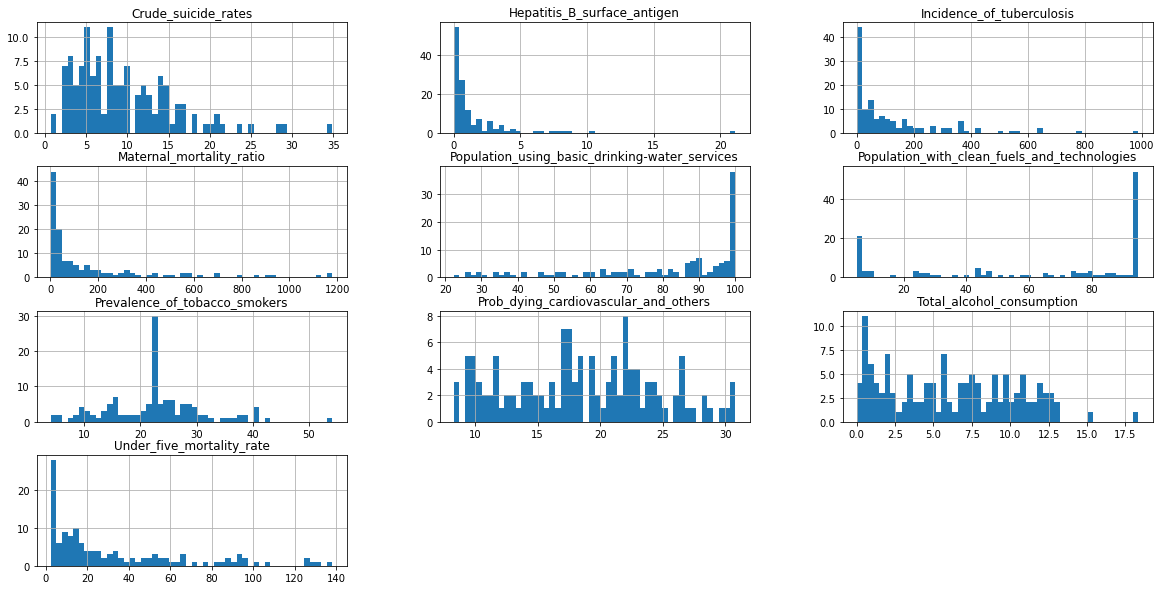

In [60]:
X_df.hist(bins=50, figsize=(20, 10))
plt.show()

Let's now plot the target variable:

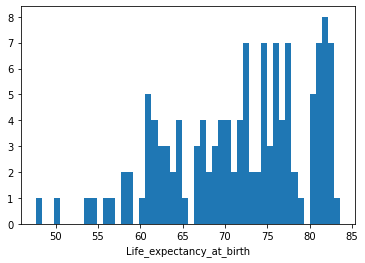

In [61]:
plt.hist(y_train, bins=50)
plt.xlabel('Life_expectancy_at_birth')
plt.show()

It appears that together with the target variable (`y_train`, _i.e._ `Life_expectancy_at_birth`), also the following features need transformations to make their distributions looking more Gaussian:
- `Crude_suicide_rates`
- `Hepatitis_B_surface_antigen`
- `Incidence_of_tuberculosis`
- `Maternal_mortality_ratio`
- `Population_using_basic_drinking-water_services`
- `Total_alcohol_consumption`
- `Under_five_mortality_rate`

Instead, the feature `Population_with_clean_fuels_and_technologies` presents with a bi-modal distribution, which will also be addressed.

Let's create our pipelines, by starting with the log transformations, and then going ahead with quantile distributions. These transformations have been decided after preliminar plots of the resulting distributions.

In [62]:
#log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

In [63]:
#quant_transformer = QuantileTransformer(output_distribution='normal', random_state=0)
#quant_transformer.fit(X_df['Population_using_basic_drinking-water_services'].values.reshape(-1, 1))

In [64]:
log_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(np.log1p, inverse_func=np.expm1, feature_names_out="one-to-one")),
    ("minmax_scaler", MinMaxScaler())
])

In [65]:
quant_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("quant_transform", QuantileTransformer(output_distribution='normal', random_state=0)),
    ("minmax_scaler", MinMaxScaler())
])

In [66]:
log_features = ["Crude_suicide_rates",
                "Hepatitis_B_surface_antigen",
                "Incidence_of_tuberculosis"]

quant_features = ["Population_using_basic_drinking-water_services",
                  "Maternal_mortality_ratio",
                  "Total_alcohol_consumption",
                  "Under_five_mortality_rate",
                  "Population_with_clean_fuels_and_technologies"]

Now, let's concatenate them in `ColumnTransformer`.

In [67]:
preprocessing = ColumnTransformer([
    ("quant_trans", quant_pipeline, quant_features),
    ("log_trans", log_pipeline, log_features)
])

In [68]:
strat_train_set_prep = preprocessing.fit_transform(strat_train_set)
strat_train_set_prep_df = pd.DataFrame(strat_train_set_prep, columns=quant_features+log_features) 
strat_train_set_prep_df

,Population_using_basic_drinking-water_services,Maternal_mortality_ratio,Total_alcohol_consumption,Under_five_mortality_rate,Population_with_clean_fuels_and_technologies,Crude_suicide_rates,Hepatitis_B_surface_antigen,Incidence_of_tuberculosis
0,0.513224,0.473296,0.389375,0.442065,1.000000,0.434630,0.047637,0.654061
1,0.425335,0.532630,0.417443,0.515128,0.410415,0.407961,0.440135,0.647543
2,0.414687,0.607052,0.574665,0.585313,0.466371,0.693597,0.196060,0.938918
3,0.473296,0.509431,0.531635,0.517038,0.491514,0.550028,0.128123,0.713382
4,0.562518,0.373252,0.536649,0.334861,1.000000,0.814694,0.347218,0.410807
...,...,...,...,...,...,...,...,...
124,0.000000,0.614357,0.429096,0.653963,0.000000,0.444719,0.284401,0.838637
125,0.481046,0.517038,0.471333,0.488675,0.508486,0.196968,0.044856,0.247183
126,0.405959,0.494347,0.603620,0.511325,0.457197,0.693597,0.320922,0.878893
127,0.338831,0.582557,0.555693,0.631382,0.430326,0.764423,0.731472,0.747212


Now let's apply a very simple pipeline to our target variable in `y_train` and `y_test`, without imputation because there are no missing values.

In [69]:
targ_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler())
])

In [70]:
targ_lab = ["Life_expectancy_at_birth"]
y_train_df = pd.DataFrame(y_train, columns=targ_lab)

In [71]:
preprocessing_targ = ColumnTransformer([
    ("targ_scal", targ_pipeline, targ_lab)
])

In [72]:
y_train_prep = preprocessing_targ.fit_transform(y_train_df)
y_train_prep_df = pd.DataFrame(y_train_prep, columns=targ_lab)
y_train_prep_df

,Life_expectancy_at_birth
0,0.758832
1,0.474826
2,0.177469
3,0.665369
4,1.000000
...,...
124,0.355216
125,0.783866
126,0.554659
127,0.374409


## Let's now do model training and model selection

Let's start with a simple linear regression using a pipeline:

In [73]:
lin_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("linear_regression", LinearRegression())
])

Exceptionally we use as in A. Géron's book, the original target variable values, _i.e._ not scaled with `MinMaxScaler()`.

### Linear Regression

In [74]:
lin_reg.fit(strat_train_set, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('quant_transform',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=0)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Population_using_basic_drinking-water_services',
                                                   'Maternal_mortality_ratio',
                                                   'Total_alcoho...
                                                 ('log_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Crude_suicide_rates',
                                                   'Hepatitis_B_surface_antigen',
                                                   'Incidence_of_tuberculosis'])])),
                ('linear_regression', LinearRegression())])

Let's now look at our life expectancy predictions and let's compare them to out target values:

In [75]:
lifeexp_pred_lr = lin_reg.predict(strat_train_set)
lifeexp_pred_lr[0:5].round(2)

array([74.51, 67.83, 63.92, 69.43, 77.84])

In [76]:
y_train[0:5].values.round(2)

array([74.95, 64.74, 54.05, 71.59, 83.62])

Let's get the RMSE:

In [77]:
lin_rmse = mean_squared_error(y_train, lifeexp_pred_lr, squared=False)
round(lin_rmse, 3)

3.301

### Decision Tree Regression

Let's now try a Decision Tree Regression.

In [78]:
tree_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("decision_tree", DecisionTreeRegressor(random_state=0))
])

In [79]:
tree_reg.fit(strat_train_set, y_train_df)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('quant_transform',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=0)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Population_using_basic_drinking-water_services',
                                                   'Maternal_mortality_ratio',
                                                   'Total_alcoho...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Crude_suicide_rates',
                                                   'Hepatitis_B_surface_antigen',
                                                   'Incidence_of_tuberculosis'])])),
                ('decision_tree', DecisionTreeRegressor(random_state=0))])

In [80]:
lifeexp_pred_dt = tree_reg.predict(strat_train_set)
lifeexp_pred_dt[0:5]

array([74.95, 64.74, 54.05, 71.59, 83.62])

In [81]:
y_train.values[0:5]

array([74.95, 64.74, 54.05, 71.59, 83.62])

In [82]:
dt_rmse = mean_squared_error(y_train, lifeexp_pred_dt, squared=False)
dt_rmse

0.0

Clear overfit! Anyways, let's perform k-fold cross-validation.

In [83]:
dt_kf_rmse = -cross_val_score(tree_reg, strat_train_set, y_train_df, 
                              scoring='neg_root_mean_squared_error', cv=10)
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
print(dt_kf_rmse)
pd.Series(dt_kf_rmse).describe().round(3)

[3.27539898 4.47299504 3.03952805 3.55317085 4.73148375 3.00318165
 2.72224737 3.20061533 1.82986759 4.19192478]


count    10.000
mean      3.402
std       0.872
min       1.830
25%       3.012
50%       3.238
75%       4.032
max       4.731
dtype: float64

So, the RMSE in the validation set is clearly larger than in the training set, a clear sign of overfitting.

Let's perform k-fold cross-validation also on the linear regression to compare the results:

In [84]:
lr_kf_rmse = -cross_val_score(lin_reg, strat_train_set, y_train_df,
                              scoring='neg_root_mean_squared_error', cv=10)
print(lr_kf_rmse)
pd.Series(lr_kf_rmse).describe()

[4.26412416 5.41684355 2.33903046 3.58750808 4.45962082 3.2260444
 4.3559263  3.49848858 2.59450292 2.27351947]


count    10.000000
mean      3.601561
std       1.030817
min       2.273519
25%       2.752388
50%       3.542998
75%       4.332976
max       5.416844
dtype: float64

So, despite the bad overfit problem, the unconstrained Decision Tree appears to perform slightly better than the Linear regression in terms of k-fold cross-validation RMSE.

### Random Forest Regressor

Let's now try a Random Forest Regressor.

In [85]:
forest_reg = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=0))
])

In [86]:
forest_reg.fit(strat_train_set, y_train_df)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('quant_transform',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=0)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Population_using_basic_drinking-water_services',
                                                   'Maternal_mortality_ratio',
                                                   'Total_alcoho...
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Crude_suicide_rates',
                                                   'Hepatitis_B_surface_antigen',
                                                   'Incidence_of_tuberculosis'])])),
                ('random_forest', RandomForestRegressor(random_state=0))])

Let's now compute the predictions:

In [87]:
lifeexp_pred_rf = forest_reg.predict(strat_train_set)
lifeexp_pred_rf[0:5]

array([75.3336, 66.9159, 56.7892, 72.113 , 82.0978])

In [88]:
y_train.values[0:5]

array([74.95, 64.74, 54.05, 71.59, 83.62])

In [89]:
rf_rmse = mean_squared_error(y_train, lifeexp_pred_rf, squared=False)
round(rf_rmse, 3)

1.159

Let's now perform cross-validation:

In [90]:
rf_kf_rmse = -cross_val_score(forest_reg, strat_train_set, y_train_df,
                              scoring='neg_root_mean_squared_error', cv=10)
print(rf_kf_rmse)
pd.Series(rf_kf_rmse).describe()

[3.70744557 4.16460511 2.58381731 2.79187719 3.66683647 2.26395303
 1.87454925 3.32369182 1.83040819 2.853213  ]


count    10.000000
mean      2.906040
std       0.798079
min       1.830408
25%       2.343919
50%       2.822545
75%       3.581050
max       4.164605
dtype: float64

This seems to be an improvement in the k-fold cross-validation with respect to the previous linear regression and cross-validation. However, our training error is still quite lower than the average k-fold cross-validation error, so it appears that some overfitting is going on. 

## Fine-tuning the model

### Grid Search

Let's now experiment with `GridSearchCV`, which will use cross-validation to evaluate all the possible combinations of hyperparameter values. Let's do that for our best model from the one above, _i.e._ the Random Forest Regressor.

In [91]:
param_grid=[
    {'random_forest__max_depth': [5, 10, 15, 20],
     'random_forest__min_samples_leaf': [1, 3, 5, 10]},
    {'random_forest__n_estimators': [100, 300, 500],
     'random_forest__max_depth': [25, 30]}
]

In [92]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_root_mean_squared_error')

In [93]:
grid_search.fit(strat_train_set, y_train_df)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('quant_trans',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('quant_transform',
                                                                                          QuantileTransformer(output_distribution='normal',
                                                                                                              random_state=0)),
                                                                                         ('minmax_scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Population_using_basic_drinking-water_services',
                                                                          'Maternal_mo...
                                                                         ['Crude_suicide_rates',
                                                                          'Hepatitis_B_surface_antigen',
                                                                          'Incidence_of_tuberculosis'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=0))]),
             param_grid=[{'random_forest__max_depth': [5, 10, 15, 20],
                          'random_forest__min_samples_leaf': [1, 3, 5, 10]},
                         {'random_forest__max_depth': [25, 30],
                          'random_forest__n_estimators': [100, 300, 500]}],
             scoring='neg_root_mean_squared_error')

In [94]:
grid_search.best_params_

{'random_forest__max_depth': 5, 'random_forest__min_samples_leaf': 3}

In [95]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('quant_transform',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=0)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Population_using_basic_drinking-water_services',
                                                   'Maternal_mortality_ratio',
                                                   'Total_alcoho...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Crude_suicide_rates',
                                                   'Hepatitis_B_surface_antigen',
                                                   'Incidence_of_tuberculosis'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=3,
                                       random_state=0))])

In [96]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.092216,0.006139,0.012394,0.001374,5,3,NaN,"{'random_forest__max_depth': 5, 'random_forest...",-4.445569,-2.391229,-3.171292,-2.492610,-2.351259,-2.970392,0.795429,1
13,0.091271,0.003565,0.011412,0.000565,20,3,NaN,"{'random_forest__max_depth': 20, 'random_fores...",-4.443755,-2.400285,-3.156317,-2.524001,-2.366726,-2.978217,0.786608,2
5,0.088516,0.001392,0.011109,0.000215,10,3,NaN,"{'random_forest__max_depth': 10, 'random_fores...",-4.443755,-2.400285,-3.156317,-2.524001,-2.366726,-2.978217,0.786608,2
9,0.103776,0.009494,0.013269,0.001304,15,3,NaN,"{'random_forest__max_depth': 15, 'random_fores...",-4.443755,-2.400285,-3.156317,-2.524001,-2.366726,-2.978217,0.786608,2
0,0.102358,0.008919,0.013075,0.002412,5,1,NaN,"{'random_forest__max_depth': 5, 'random_forest...",-4.459036,-2.443721,-3.209776,-2.512501,-2.279827,-2.980972,0.804578,5
19,0.110070,0.007856,0.013039,0.001554,30,NaN,100,"{'random_forest__max_depth': 30, 'random_fores...",-4.447507,-2.473284,-3.209516,-2.528189,-2.278166,-2.987332,0.794915,6
8,0.119705,0.010927,0.013761,0.000935,15,1,NaN,"{'random_forest__max_depth': 15, 'random_fores...",-4.447507,-2.473284,-3.209516,-2.528189,-2.278166,-2.987332,0.794915,6
16,0.095596,0.000614,0.011820,0.000965,25,NaN,100,"{'random_forest__max_depth': 25, 'random_fores...",-4.447507,-2.473284,-3.209516,-2.528189,-2.278166,-2.987332,0.794915,6
12,0.096796,0.003884,0.011520,0.000563,20,1,NaN,"{'random_forest__max_depth': 20, 'random_fores...",-4.447507,-2.473284,-3.209516,-2.528189,-2.278166,-2.987332,0.794915,6
4,0.094131,0.000859,0.011637,0.000635,10,1,NaN,"{'random_forest__max_depth': 10, 'random_fores...",-4.471462,-2.482770,-3.197270,-2.540467,-2.296898,-2.997773,0.797137,10


### Randomized Search

Keep in mind: for each hyperparameter you must provide either a list of possible values, or a probability distribution:

In [97]:
param_distribs = {'random_forest__max_depth': randint(low=1, high=20),
                  'random_forest__min_samples_leaf': randint(low=1, high=10)}

In [98]:
rnd_search = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs,
                                n_iter=100,
                                cv=5,
                                scoring='neg_root_mean_squared_error',
                                random_state=0
)

In [99]:
rnd_search.fit(strat_train_set, y_train_df)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('quant_trans',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('quant_transform',
                                                                                                QuantileTransformer(output_distribution='normal',
                                                                                                                    random_state=0)),
                                                                                               ('minmax_scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['Population_using_basic_drinking-water_services',
                                                                                'Mater...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=0))]),
                   n_iter=100,
                   param_distributions={'random_forest__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f40d1b0dde0>,
                                        'random_forest__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f40d1b0ca00>},
                   random_state=0, scoring='neg_root_mean_squared_error')

In [100]:
rnd_search.best_params_

{'random_forest__max_depth': 13, 'random_forest__min_samples_leaf': 2}

In [101]:
rnd_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('quant_trans',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('quant_transform',
                                                                   QuantileTransformer(output_distribution='normal',
                                                                                       random_state=0)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Population_using_basic_drinking-water_services',
                                                   'Maternal_mortality_ratio',
                                                   'Total_alcoho...
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>)),
                                                                  ('minmax_scaler',
                                                                   MinMaxScaler())]),
                                                  ['Crude_suicide_rates',
                                                   'Hepatitis_B_surface_antigen',
                                                   'Incidence_of_tuberculosis'])])),
                ('random_forest',
                 RandomForestRegressor(max_depth=13, min_samples_leaf=2,
                                       random_state=0))])

In [102]:
cv_rnd_res = pd.DataFrame(rnd_search.cv_results_)
cv_rnd_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_rnd_res.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,0.090258,0.001419,0.010964,0.000298,17,2,"{'random_forest__max_depth': 17, 'random_fores...",-4.412032,-2.396046,-3.190645,-2.502468,-2.318169,-2.963872,0.787508,1
6,0.095133,0.004688,0.011191,0.000078,13,2,"{'random_forest__max_depth': 13, 'random_fores...",-4.412032,-2.396046,-3.190645,-2.502468,-2.318169,-2.963872,0.787508,1
56,0.089601,0.000452,0.011028,0.000164,15,2,"{'random_forest__max_depth': 15, 'random_fores...",-4.412032,-2.396046,-3.190645,-2.502468,-2.318169,-2.963872,0.787508,1
81,0.091827,0.001696,0.011111,0.000244,16,2,"{'random_forest__max_depth': 16, 'random_fores...",-4.412032,-2.396046,-3.190645,-2.502468,-2.318169,-2.963872,0.787508,1
20,0.087541,0.001651,0.010952,0.000171,4,3,"{'random_forest__max_depth': 4, 'random_forest...",-4.459330,-2.382385,-3.190732,-2.493327,-2.355465,-2.976248,0.802097,5
46,0.086919,0.001144,0.011063,0.000316,4,3,"{'random_forest__max_depth': 4, 'random_forest...",-4.459330,-2.382385,-3.190732,-2.493327,-2.355465,-2.976248,0.802097,5
97,0.087955,0.001715,0.011119,0.000199,4,3,"{'random_forest__max_depth': 4, 'random_forest...",-4.459330,-2.382385,-3.190732,-2.493327,-2.355465,-2.976248,0.802097,5
83,0.087315,0.001260,0.011780,0.000874,4,3,"{'random_forest__max_depth': 4, 'random_forest...",-4.459330,-2.382385,-3.190732,-2.493327,-2.355465,-2.976248,0.802097,5
50,0.089588,0.001915,0.010973,0.000112,11,3,"{'random_forest__max_depth': 11, 'random_fores...",-4.443755,-2.400285,-3.156317,-2.524001,-2.366726,-2.978217,0.786608,9
59,0.089733,0.002193,0.011078,0.000315,12,3,"{'random_forest__max_depth': 12, 'random_fores...",-4.443755,-2.400285,-3.156317,-2.524001,-2.366726,-2.978217,0.786608,9


In this case, the Random Search provided a combination outputting a slightly better cross-validation mean RMSE score compared to the Grid Search.

### Analyzing the Best Models and Their Errors

Let's analyze the relative importance of our features:

In [103]:
final_model = rnd_search.best_estimator_ # it includes the preprocessing

In [104]:
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.06, 0.04, 0.01, 0.71, 0.11, 0.01, 0.01, 0.04])

In [105]:
sorted(zip(feature_importances.round(3),
           final_model["preprocessing"].get_feature_names_out()),
           reverse=True)

[(0.711, 'quant_trans__Under_five_mortality_rate'),
 (0.109, 'quant_trans__Population_with_clean_fuels_and_technologies'),
 (0.061, 'quant_trans__Population_using_basic_drinking-water_services'),
 (0.044, 'quant_trans__Maternal_mortality_ratio'),
 (0.044, 'log_trans__Incidence_of_tuberculosis'),
 (0.013, 'log_trans__Hepatitis_B_surface_antigen'),
 (0.012, 'log_trans__Crude_suicide_rates'),
 (0.007, 'quant_trans__Total_alcohol_consumption')]

## Evaluating the final model on the test set

Let's now finally evaluate our model on the test set.

In [106]:
final_predictions = final_model.predict(strat_test_set)

In [107]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(round(final_rmse, 3))

2.939


Let's now compute a 95% confidence interval of the generalization error.

In [108]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([2.03220084, 3.62538216])